## Getting started:

[Link to GOOGLE COLLAB](https://colab.research.google.com/drive/1JKN9LzayqykwTeIsK_vhELFGsguXUN4z?usp=sharing)

1. Click on "$\vee$ " next to the "Code" section to hide the code (for readability).

2. Hover above "11 cells hidden" below the code section and click the play button to load the necessary code. It will run for a couple of seconds.

3. Go over the remaining sections, read the text, and execute the code cells along the way by clicking the 'play' button at each cell.

# Code

## Installs (hide)

In [ ]:
!pip install nlopt
!pip install ipywidgets
!pip install cvxopt


In [ ]:
import ipywidgets as widgets
from IPython.display import display


import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np
from scipy.sparse import coo_matrix

from typing import Optional, Union
import dataclasses
import functools
import cvxopt
import cvxopt.cholmod

X, Y = 0, 1

## Simulation code: FEM (hide)




In [ ]:
def get_stiffness_matrix(young, poisson):
    # Element stiffness matrix
    e, nu = young, poisson
    k = np.array([1/2-nu/6, 1/8+nu/8, -1/4-nu/12, -1/8+3*nu/8,
                  -1/4+nu/12, -1/8-nu/8, nu/6, 1/8-3*nu/8])
    return e/(1-nu**2)*np.array([[k[0], k[1], k[2], k[3], k[4], k[5], k[6], k[7]],
                                 [k[1], k[0], k[7], k[6], k[5], k[4], k[3], k[2]],
                                 [k[2], k[7], k[0], k[5], k[6], k[3], k[4], k[1]],
                                 [k[3], k[6], k[5], k[0], k[7], k[2], k[1], k[4]],
                                 [k[4], k[5], k[6], k[7], k[0], k[1], k[2], k[3]],
                                 [k[5], k[4], k[3], k[2], k[1], k[0], k[7], k[6]],
                                 [k[6], k[3], k[4], k[1], k[2], k[7], k[0], k[5]],
                                 [k[7], k[2], k[1], k[4], k[3], k[6], k[5], k[0]]
                                 ])


def inverse_permutation(indices):
    inverse_perm = np.zeros(len(indices), dtype=np.int64)
    inverse_perm[indices] = np.arange(len(indices), dtype=np.int64)
    return inverse_perm

def _get_dof_indices(freedofs, fixdofs, k_xlist, k_ylist):
    index_map = inverse_permutation(
        np.concatenate([freedofs, fixdofs]))
    keep = np.isin(k_xlist, freedofs) & np.isin(k_ylist, freedofs)
    i = index_map[k_ylist][keep]
    j = index_map[k_xlist][keep]
    return index_map, keep, np.stack([i, j])


def get_k(stiffness, ke):
    nely, nelx = stiffness.shape
    # get position of the nodes of each element in the stiffness matrix
    ely, elx = np.meshgrid(np.arange(nely), np.arange(nelx))  # x, y coords
    ely, elx = ely.reshape(-1, 1), elx.reshape(-1, 1)

    n1 = (nely+1)*(elx+0) + (ely+0)
    n2 = (nely+1)*(elx+1) + (ely+0)
    n3 = (nely+1)*(elx+1) + (ely+1)
    n4 = (nely+1)*(elx+0) + (ely+1)
    edof = np.array([2*n1, 2*n1+1, 2*n2, 2*n2+1, 2*n3, 2*n3+1, 2*n4, 2*n4+1])
    edof = edof.T[0]

    x_list = np.repeat(edof, 8)  # flat list pointer of each node in an element
    # flat list pointer of each node in elem
    y_list = np.tile(edof, 8).flatten()
    # make the stiffness matrix
    kd = stiffness.T.reshape(nelx*nely, 1, 1)
    value_list = (kd * np.tile(ke, kd.shape)).flatten()
    return value_list, y_list, x_list


def young_modulus(x, e_0, e_min, p=3):
    return e_min + x ** p * (e_0 - e_min)

def compliance(x_phys, u, ke, *, penal=3, e_min=1e-9, e_0=1, elementwise=True,
               u2 = None):
    if u2 is None:
        u2 = u
    # index map
    nely, nelx = x_phys.shape
    ely, elx = np.meshgrid(np.arange(nely), np.arange(nelx))  # x, y coords
    # nodes
    n1 = (nely+1)*(elx+0) + (ely+0)
    n2 = (nely+1)*(elx+1) + (ely+0)
    n3 = (nely+1)*(elx+1) + (ely+1)
    n4 = (nely+1)*(elx+0) + (ely+1)
    all_ixs = np.array([2*n1, 2*n1+1, 2*n2, 2*n2+1,
                       2*n3, 2*n3+1, 2*n4, 2*n4+1])
    # select from u matrix
    u_selected = u[all_ixs]
    u_selected2 = u2[all_ixs]

    # compute x^penal * U.T @ ke @ U in a vectorized way
    ke_u = np.einsum('ij,jkl->ikl', ke, u_selected)
    ce = np.einsum('ijk,ijk->jk', u_selected2, ke_u)
    return ce.T

def calculate_forces(x_phys, args):
    applied_force = args['forces']
    if not args.get('g'):
        return applied_force
    density = 0
    for pad_left in [0, 1]:
        for pad_up in [0, 1]:
            padding = [(pad_left, 1 - pad_left), (pad_up, 1 - pad_up)]
            density += (1/4) * np.pad(
                x_phys.T, padding, mode='constant', constant_values=0
            )
    gravitional_force = -args['g'] * \
        density[..., np.newaxis] * np.array([0, 1])
    return applied_force + gravitional_force.ravel()

def displace_cvxopt(x_phys, ke, forces, freedofs, fixdofs, *,
                    penal=3, e_min=1e-9, e_0=1):
    # Displaces the load x using finite element techniques. The spsolve here
    # occupies the majority of this entire simulation's runtime.
    stiffness = young_modulus(x_phys, e_0, e_min, p=penal)
    k_entries, k_ylist, k_xlist = get_k(stiffness, ke)

    index_map, keep, indices = _get_dof_indices(
        freedofs, fixdofs, k_ylist, k_xlist
    )

    K = cvxopt.spmatrix(k_entries[keep], indices[0, :], indices[1, :])
    B = cvxopt.matrix(forces[freedofs])
    cvxopt.cholmod.linsolve(K, B)
    u_nonzero = np.array(B)
    u_values = np.concatenate([u_nonzero[:, 0], np.zeros(len(fixdofs))])

    return u_values[index_map]

def compliance_cvxopt(x_phys, args):
    # , volume_contraint=True, cone_filter=True):
    """Objective function (compliance) for topology optimization."""
    ke = get_stiffness_matrix(args['young'], args['poisson'])
    kwargs = dict(penal=args['penal'],
                  e_min=args['young_min'], e_0=args['young'])
    # x_phys = physical_density(x, args, volume_contraint=volume_contraint,
    #                           cone_filter=cone_filter)
    forces = calculate_forces(x_phys, args)

    u = displace_cvxopt(x_phys, ke, forces,
                        args['freedofs'], args['fixdofs'], **kwargs)

    J = compliance(x_phys, u, ke, elementwise=True, **kwargs)
    return J, u


def get_triangles(nely, nelx):
    ely, elx = np.meshgrid(np.arange(nely)[::-1], np.arange(nelx))  # x, y coords
    # nodes
    n1 = (nely+1)*(elx+0) + (ely+0)
    n2 = (nely+1)*(elx+1) + (ely+0)
    n3 = (nely+1)*(elx+1) + (ely+1)
    n4 = (nely+1)*(elx+0) + (ely+1)
    all_ixs = np.array([2*n1, 2*n1+1, 2*n2, 2*n2+1,
                        2*n3, 2*n3+1, 2*n4, 2*n4+1])

    # select from u matrix
    tri1 = np.array([n1, n2, n3]).reshape(3, -1)
    tri2  = np.array([n1, n3, n4]).reshape(3, -1)

    triangles = np.concatenate([tri1, tri2], axis=1)
    return triangles



def plot_results(results, design,
                 mesh_deformation_scale = 0.2,
                 power_scale = 0.3,
                 mask_strain_energy = False):


    ce, u, mass = results
    ux = u.reshape(-1, 2)[:, 0]
    uy = u.reshape(-1, 2)[:, 1]

    ux = ux.reshape(u.shape[1], u.shape[0])[:, ::-1].flatten()



    nely, nelx = ce.shape
    triangles = get_triangles(nely, nelx)

    x, y = np.meshgrid(np.arange(nelx+1), np.arange(nely+1)[::-1])
    #y = nely + 1 - y
    scale = mesh_deformation_scale * y.max()/np.abs(uy).max()


    dx = -scale * ux
    dy =  scale  * uy

    #triang = tri.Triangulation(x.flatten(order = 'F'), y.flatten(order = 'F'), triangles=triangles.T)

    x = x  + dx.reshape((nely+1, nelx+1), order = 'F')
    y = y  + dy.reshape((nely+1, nelx+1), order = 'F')
    mask = design.flatten(order = 'F').round()
    mask = 1 - np.hstack([mask, mask]).flatten()
    triang_deformed = tri.Triangulation(x.flatten(order = 'F'),
                                         y.flatten(order = 'F'),
                                           triangles=triangles.T,
                                           mask =mask)


    # tricontour plot
    plt.figure(figsize = (12, 4))
    plt.subplot(131)
    plt.gca().set_aspect('equal')
    plt.tricontourf(triang_deformed, ux )
    #plt.triplot(triang_deformed, 'ko-', lw=0.5, ms=3)
    plt.colorbar()
    plt.title('Displacement in x')
    plt.axis('off')

    plt.subplot(132)
    plt.gca().set_aspect('equal')
    #plt.triplot(triang_deformed, 'ko-', lw=0.5, ms=3)
    plt.tricontourf(triang_deformed, uy)
    plt.colorbar()
    plt.title('Displacement in y')
    # turn axes off
    plt.axis('off')

    plt.subplot(133)
    plt.gca().set_aspect('equal')
    #plt.triplot(triang_deformed, 'ko-', lw=0.5, ms=3)
    if mask_strain_energy:
        ce = (0.001 * design **3) * ce
    else:
        triang_deformed = tri.Triangulation(x.flatten(order = 'F'),
                                         y.flatten(order = 'F'),
                                           triangles=triangles.T)

    ce = ce ** power_scale
    #ce = ce]
    plt.tripcolor(triang_deformed,
                  np.hstack([ce.flatten(order = 'F'),
                             ce.flatten(order = 'F')] ).flatten(),
                             cmap = 'plasma')
    plt.colorbar()
    plt.title('Strain Energy')
    # turn axes off
    plt.axis('off')

def apply_filter(x, args):
    rmin = args['filter_width']
    nely = args['nely']
    nelx = args['nelx']
    mask = args['mask']
    nfilter=int(nelx*nely*((2*(np.ceil(rmin)-1)+1)**2))
    iH = np.zeros(nfilter)
    jH = np.zeros(nfilter)
    sH = np.zeros(nfilter)
    cc=0
    for i in range(nely):
       for j in range(nelx):
            row=i*nelx+j
            kk1=int(np.maximum(i-(np.ceil(rmin)-1),0))
            kk2=int(np.minimum(i+np.ceil(rmin),nely))
            ll1=int(np.maximum(j-(np.ceil(rmin)-1),0))
            ll2=int(np.minimum(j+np.ceil(rmin),nelx))
            for k in range(kk1,kk2):
                for l in range(ll1,ll2):
                    col=k*nelx+l
                    fac=rmin-np.sqrt(((i-k)*(i-k)+(j-l)*(j-l)))
                    iH[cc]=row
                    jH[cc]=col
                    sH[cc]=np.maximum(0.0,fac)
                    cc=cc+1
    # Finalize assembly and convert to csc format
    H=coo_matrix((sH,(iH,jH)),shape=(nelx*nely,nelx*nely)).tocsc().transpose()
    Hs=H.sum(1)

    xPhys=np.asarray(H*x[np.newaxis].T/Hs)[:,0]
    xPhys = xPhys.reshape((nely,nelx)) *mask
    return xPhys

def simulate(args, x, filtering = True):
    nelx = args['nelx']
    nely = args['nely']
    shell = args['shell']
    mask = args['mask']

    x =x.reshape((nely, nelx))
    x = x *(1 - shell) + shell
    x = x.flatten()


    if filtering:
      xPhys = apply_filter(x, args).reshape(x.shape)
    else:
      xPhys = x

    xPhys = xPhys.reshape((nely,nelx)) *mask

    ce, u = compliance_cvxopt(xPhys.reshape((nely,nelx)), args)
    mass = xPhys.sum() * 0.1 * 2.7
    return (ce.reshape((nely, nelx)),
            u.reshape((nely+1, nelx+1, 2)),
            mass)






### Visualizing the BCs

In [ ]:

def visualize_bcs(problem, design = None,
                  step_size = 2):
  nely = problem.height
  nelx = problem.width

  if design is None:
    design = 0.2 * np.ones((nely, nelx))


  forces_y = problem.forces[:, :, 1].T
  forces_x = problem.forces[:, :, 0].T

  forces_mag = np.abs(forces_x) + np.abs(forces_y)

  supports_x = problem.normals[:, :, 0].T
  supports_y = problem.normals[:, :, 1].T


  plt.imshow(design, cmap='gray_r', origin='lower', vmin = 0., vmax = 1.0)
  supports_x[supports_x ==0.0] = np.nan
  supports_y[supports_y == 0.0] = np.nan
  plt.imshow(supports_x, cmap = 'winter', label = 'supports x', origin = 'lower')
  plt.imshow(supports_y, cmap = 'summer', label = 'supports y', origin = 'lower')

  # Get the dimensions of the array
  rows, cols = nely+1, nelx+1

  # Iterate through the array and plot downward arrows where there is a 1
  ctr = 0

  for i in range(0, rows, 1):
      for j in range(0, cols, 1):
          if forces_mag[i, j] != 0:
            if ctr%step_size ==0:
              vx = forces_x[i, j]
              vy = forces_y[i, j]
              plt.arrow(j - 0.5, i - 0.5,
                        + 5. *vx/np.abs(vx + 1e-6),
                        + 5. *vy/np.abs(vy),
                        head_width=2, head_length=1.,
                        fc='red', ec='red')
            ctr = ctr +1
  # Set the x and y axis limits
  plt.xlim(-10, cols + 10.)
  plt.ylim(-10, rows + 10,)



## Problem definitions

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
nely, nelx = 32, 128
from skimage.transform import resize

X, Y = 0, 1

def load_image_as_grayscale(image_path):
    # Open the image using PIL
    img = Image.open(image_path).convert('RGBA')  # Convert to RGBA to ensure there's an alpha channel

    # Split the image into its R, G, B, and A components
    r, g, b, a = img.split()

    # Convert the image to grayscale using the formula: grayscale = 0.299*R + 0.587*G + 0.114*B
    grayscale = Image.merge("RGB", (r, g, b)).convert("L")

    # Convert the grayscale image to a numpy array and normalize to 0-1
    grayscale_array = np.asarray(grayscale).astype(np.float32) / 255.0

    # Convert the alpha channel to a numpy array and normalize to 0-1
    alpha_array = np.asarray(a).astype(np.float32) / 255.0

    # Treat the alpha channel as white color: if alpha < 1, set corresponding grayscale value to 1 (black)
    grayscale_array[alpha_array < 1] = 1.0

    # Invert the grayscale array to satisfy the condition: 1 corresponds to black, 0 to white
    inverted_array = 1.0 - grayscale_array

    inverted_array = resize(inverted_array, (nely, nelx))

    inverted_array = np.round(inverted_array)

    return inverted_array[::-1 ,:]

@dataclasses.dataclass
class Problem:
    normals: np.ndarray
    forces: np.ndarray
    density: float
    mask: Union[np.ndarray, float] = 1
    name: Optional[str] = None
    width: int = dataclasses.field(init=False)
    height: int = dataclasses.field(init=False)
    mirror_left: bool = dataclasses.field(init=False)
    mirror_right: bool = dataclasses.field(init=False)
    ud: np.ndarray = dataclasses.field(default=None)
    shell : np.ndarray = dataclasses.field(default = None)

    def __post_init__(self):
        self.width = self.normals.shape[0] - 1
        self.height = self.normals.shape[1] - 1

        if self.normals.shape != (self.width + 1, self.height + 1, 2):
            raise ValueError(f'normals has wrong shape: {self.normals.shape}')
        if self.forces.shape != (self.width + 1, self.height + 1, 2):
            raise ValueError(f'forces has wrong shape: {self.forces.shape}')
        if (isinstance(self.mask, np.ndarray)
                and self.mask.shape != (self.height, self.width)):
            raise ValueError(f'mask has wrong shape: {self.mask.shape}')

        self.mirror_left = (
            self.normals[0, :, X].all() and not self.normals[0, :, Y].all()
        )
        self.mirror_right = (
            self.normals[-1, :, X].all() and not self.normals[-1, :, Y].all()
        )

def specified_task(problem,
                   Emax = 1.0,
                   Emin = 1e-9,
                   penal = 3.0,
                   rmin = 2,
                   poisson = 0.3,
                   ):
    """Given a problem, return parameters for running a topology optimization."""
    fixdofs = np.flatnonzero(problem.normals.ravel())
    alldofs = np.arange(2 * (problem.width + 1) * (problem.height + 1))
    freedofs = np.sort(list(set(alldofs) - set(fixdofs)))

    params = {
        # material properties
        'young': Emax,
        'young_min': Emin,
        'poisson': poisson,
        'g': 0,
        # constraints
        'volfrac': problem.density,
        'xmin': 0.001,
        'xmax': 1.0,
        # input parameters
        'nelx': problem.width,
        'nely': problem.height,
        'mask': problem.mask,
        'freedofs': freedofs,
        'fixdofs': fixdofs,
        'forces': problem.forces.ravel(),
        'penal': penal,
        'filter_width': rmin,
        'ud' : problem.ud,
        'shell' : problem.shell
    }
    return params


def suspended_bridge(width=60, height=20, density=0.3, span_position=0.2,
                     anchored=False):
    """A bridge above the ground, with supports at lower corners."""
    normals = np.zeros((width + 1, height + 1, 2))
    normals[-1, :, X] = 1
    normals[:round(span_position*width), -1, Y] = 1
    if anchored:
        normals[:round(span_position*width), -1, X] = 1

    forces = np.zeros((width + 1, height + 1, 2))
    forces[:, -1, Y] = -1 / width
    return Problem(normals, forces, density)



def airfoil_problem(nelx = 128, nely = 32, density = 0.5,
                    force_on_the_bottom = True):
    Nx = nelx+1
    Ny = nely+1
    x = np.linspace(0, 1, Nx)
    R = np.sqrt(2)
    y = 2.5* (np.sqrt(R**2 - x**2) - 1)

    X = Nx * x
    Y = Ny * y
    mask = np.ones((nely, nelx))
    forces = np.zeros((Ny, Nx, 2))
    for xi in range(nelx):
        for yi in range(nely):
            if yi > Y[xi]:
                mask[yi, xi] = 0

    for xi in range(5, nelx-5):
        #forces[0, xi, 1] = 0.5
        tp = np.argwhere(mask[:,xi]>0).max()
        forces[tp, xi, 1] = 1.0 #((Nx - xi)**2)/32

    if force_on_the_bottom:
        forces[0, 5:-5, 1] = 0.5

    forces = forces/Nx
    normals = np.zeros((Ny, Nx, 2))
    normals[:, 0, :] = 1

    normals = normals.transpose(1, 0, 2)
    forces = forces.transpose(1, 0, 2)
    mask = mask

    xshell = mask.copy()
    indices = np.sum(xshell, axis = 0).astype(int)[:-2]
    for i, ind in enumerate(indices):
      xshell[2 : ind-2, i ] =0

    # plt.imshow(forces[:, :, 1], cmap='viridis', origin = 'lower')
    # plt.show()
    # plt.imshow(mask, cmap='gray_r', origin = 'lower')
    # plt.colorbar()

    #ud = np.zeros_like(forces)
    #ud[-1, 0, 1] = 1.0
    ud = forces.copy()

    return Problem(normals, forces, density, mask, ud = ud, shell = xshell)

# Case study: Optimization of a rib in aircraft wing

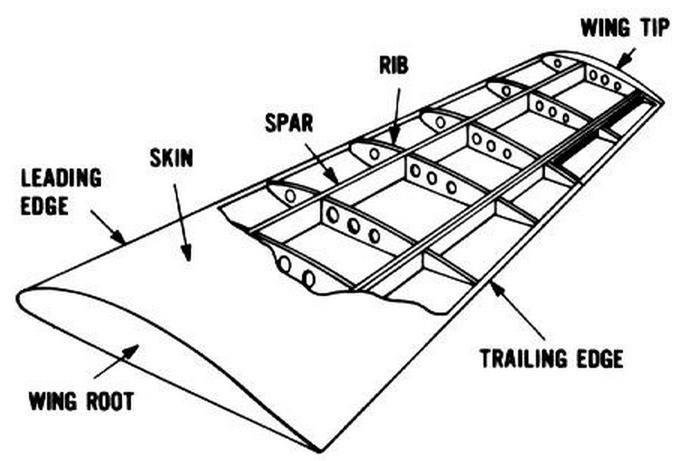

## Problem statement:

As shown below, we have a section of an aircraft wing structure - a rib. The role of the rib is to transfer the lift force from the skin to the spars and the remaining part of the aircraft structure.

The rib is attached to the spar at the left edge - marked by the green line in the drawing below. Furthermore, a lift force acts on the rib distributed along the upper and lower edges. For simplicity, we assume that the force follows a uniform distribution (the same everywhere).


###Optimization problem

**Objective**:
- minimize the weight

**Constraints**:
- the outline is constrained by the aerodynamic design (we can't change the outline).
- keep the maximum displacement within 2.0mm, in other words: $u_y \leq2.0$


*Explanation:* we aim to come up with a design that is the lightest - to save the fuel. However, we cannot allow the wing to deform too much while subject to lift force, because the change in shape would affect its aerodynamic properties.




In [ ]:
problem = airfoil_problem()
args = specified_task(problem=problem, Emax=10, Emin=1e-3, penal=3.0, rmin=2, poisson=0.3)

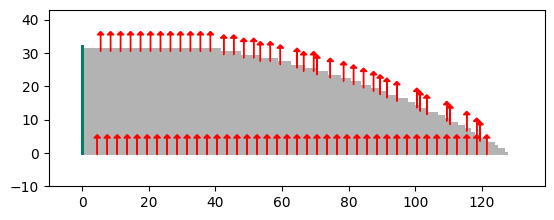

In [ ]:
visualize_bcs(problem, design = np.ones_like(args['mask']) * args['mask'] * 0.3, step_size = 3)

## Basic design: full plate

Let's evaluate the most basic design: a full plate.

Basic design - full plate


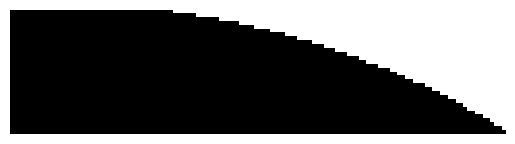

Maximum vertical displacement: 1.612
Mass: 809.677


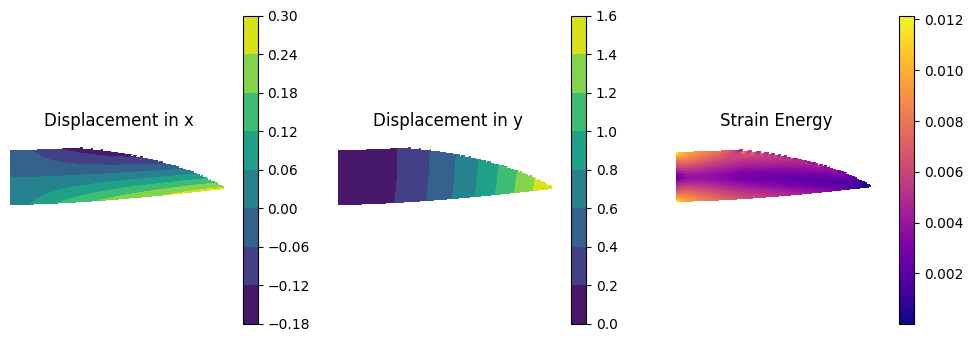

In [ ]:

print("Basic design - full plate")
x0 = args['mask']
plt.imshow(x0, origin = 'lower', cmap = 'gray_r')
plt.axis('off')
plt.show()
results = simulate(args, x0)
strain_energy, displacement, mass = results
plot_results(results, x0,
            mesh_deformation_scale= 0.3,
            power_scale = 0.3,
            mask_strain_energy = True)

print("Maximum vertical displacement: {:.3f}".format(np.max(displacement[:, :, 1])))
print("Mass: {:.3f}".format(mass))

In the top picture,  you can see our baseline design - the full plate. In the bottom figures you can see the results of the simulation, showing us how the ribs deflects once it it loaded - subject to the lift force. Displacements in x and y tell us how the wing stretches in the horizontal and vertical directions respectively. Furthermore, the simulation script prints the most important results for us: the mass of the rib and the maximum deflection (printed above the plots). As you can see, the deflection value is below the allowed value of 2.0. This suggests that we can probably remove some material, and make the rib lighter, while sacrificing a bit of its stiffness.

## Shell design

Let's see what happens when we remove all the material inside, and leave only the material along the outline - resulting in a shell design

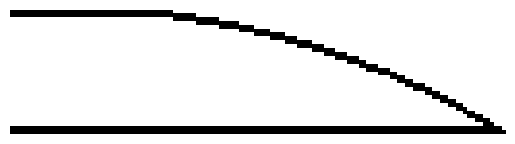

Maximum vertical displacement: 227.780
!!!Displacement too large - the wing is too flexible
Mass: 129.007


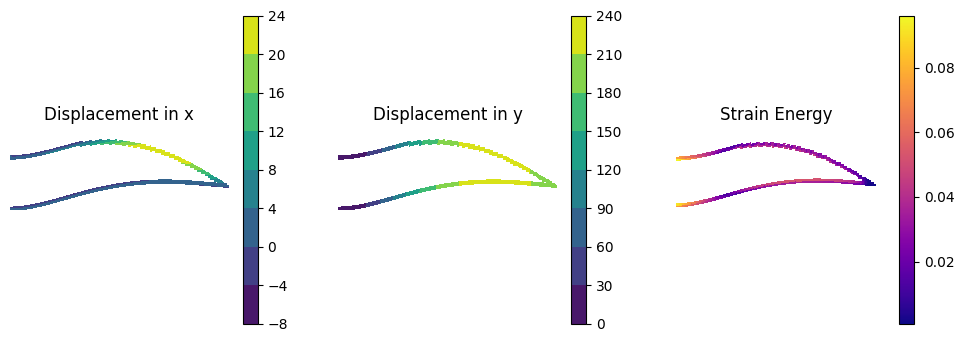

In [ ]:
x0 = args['shell']
plt.imshow(x0, origin = 'lower', cmap = 'gray_r')
plt.axis('off')
plt.show()

results = simulate(args, x0)
strain_energy, displacement, mass = results
print("Maximum vertical displacement: {:.3f}".format(np.max(displacement[:, :, 1])))
if np.max(displacement[:, :, 1])> 2.0:
  print('!!!Displacement too large - the wing is too flexible')
print("Mass: {:.3f}".format(mass))


plot_results(results, x0,
            mesh_deformation_scale= 0.5,
            power_scale = 0.3,
            mask_strain_energy = True)


As you can see, the rib is much lighter now! However it turns out to be too flexible - while loaded it deflects by 227.78 mm, which is 100 times more than the allowed limit ($u_y^{max}$ = 2.0)! The optimal design must be somewhere in between the full plate, and the shell design.

# Optimize the design (try it yourself!)

Your task will be to come up with an optimal design. You'll create your design, using one of the templates as a starting point. Next, you'll uplod the design into this notebook, and run a simulation to evaluate the performance of your design.


Steps:

1) Save on of the design templates provided below as .png file on your computer.

2) Open the image in an image editing software. You can use Microsoft Paint, or you can edit the image in the borwse - open https://sketch.io/sketchpad/ and import the image there.

3) Edit the image:
- add the material by drawing extra features with black color.
- remove the material with an eraser, or by drawing white features.

4) Save/Export the image of your design.

5) Continue to the next section: "Uploading image".




### Design templates

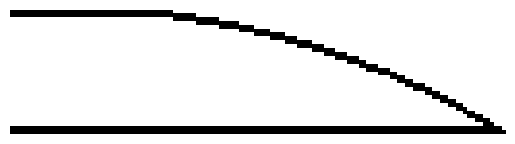

In [ ]:
x0 = args['shell']
plt.imshow(x0, origin = 'lower', cmap = 'gray_r')
plt.axis('off')
plt.show()

Basic design - full plate


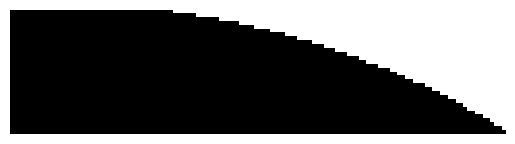

In [ ]:
print("Basic design - full plate")
x0 = args['mask']
plt.imshow(x0, origin = 'lower', cmap = 'gray_r')
plt.axis('off')
plt.show()

### Uploading the image.

Execute the cell below, click on 'choose files', and choose the file with your design to upload.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Drawing-12.sketchpad.png to Drawing-12.sketchpad.png


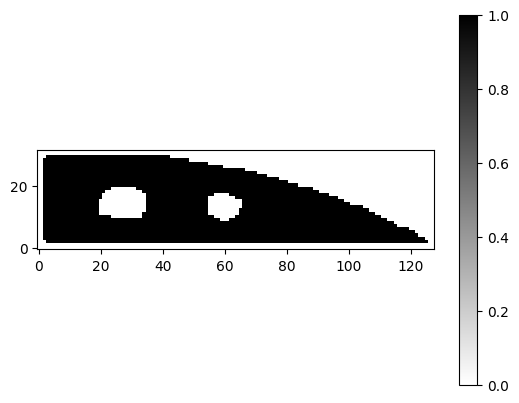

In [ ]:
# Replace the name of the file with the name of your file. E.g. here, my file name was Drawing-9.sketchpad.png,
# if your design is saved as 'my_design.png', change the line to: xt = load_image_as_grayscale('my_design.png')

xt = load_image_as_grayscale('Drawing-12.sketchpad.png')
plt.imshow(xt, cmap = 'gray_r', origin = 'lower')
plt.colorbar()

Run the simulation!

Maximum vertical displacement: 2.266
!!!Displacement too large - the wing is too flexible
Mass: 738.287


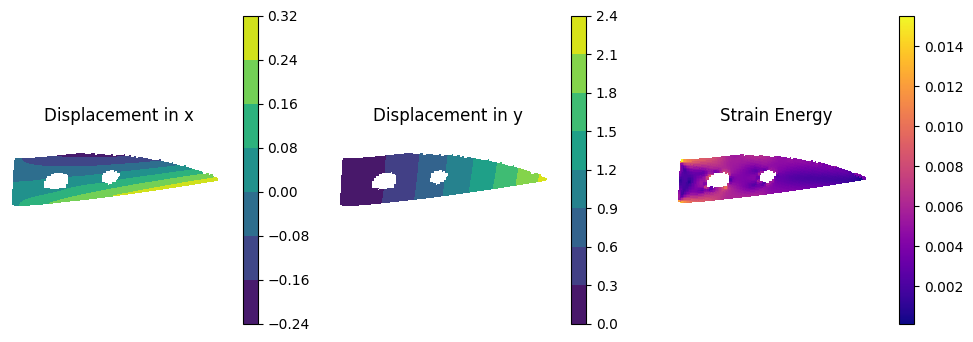

In [ ]:
results = simulate(args, xt)
strain_energy, displacement, mass = results
print("Maximum vertical displacement: {:.3f}".format(np.max(displacement[:, :, 1])))
if np.max(displacement[:, :, 1])> 2.0:
  print('!!!Displacement too large - the wing is too flexible')
print("Mass: {:.3f}".format(mass))


plot_results(results, xt,
            mesh_deformation_scale= 0.5,
            power_scale = 0.3,
            mask_strain_energy = True)


## Your design 1.

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
# Replace the name of the file with the name of your file.
# E.g. if your design is saved as 'my_design.png',
# change the line below to: xt = load_image_as_grayscale('my_design.png')


xd1 = load_image_as_grayscale('<FILL IN YOUR FILE NAME HERE>')
plt.imshow(xd1, cmap = 'gray_r', origin = 'lower')
plt.colorbar()

In [ ]:
results = simulate(args, xd1)
strain_energy, displacement, mass = results
print("Maximum vertical displacement: {:.3f}".format(np.max(displacement[:, :, 1])))
if np.max(displacement[:, :, 1])> 2.0:
  print('!!!Displacement too large - the wing is too flexible')
print("Mass: {:.3f}".format(mass))



plot_results(results, xd1,
             mesh_deformation_scale= 0.3,
             power_scale = 0.3,
             mask_strain_energy = True)



**Tip**: you can start with your design instead of the template, and try to improve: by removing or adding material. In case the displacement is larger than 2.0, you need to add material somewhere, to make it stiffere. In case the displacement is smaller than 2.0, you can probably come up with a lighter design by removing the material in certain locations.

## Your design 2.


In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
# Replace the name of the file with the name of your file.
# E.g. if your design is saved as 'my_design.png',
# change the line below to: xt = load_image_as_grayscale('my_design.png')

xd2 = load_image_as_grayscale('<FILL IN YOUR FILE NAME HERE>')
plt.imshow(xd2, cmap = 'gray_r', origin = 'lower')
plt.colorbar()

In [ ]:
results = simulate(args, xd2)
strain_energy, displacement, mass = results
print("Maximum vertical displacement: {:.3f}".format(np.max(displacement[:, :, 1])))
if np.max(displacement[:, :, 1])> 2.0:
  print('!!!Displacement too large - the wing is too flexible')
print("Mass: {:.3f}".format(mass))



plot_results(results, xd2,
             mesh_deformation_scale= 0.3,
             power_scale = 0.3,
             mask_strain_energy = True)


**Tip 2:** Take a look at the strain energy plot. Strain energy tells us how 'loaded' given piece of material is
- In places where the strain energy is high - the material is carrying a lot of load - it is important to keep material in this place.

- In places the strain energy is low, the material is not carrying lots of loads - whis means it is not used efficiently. This means we can remove material from this places, and make the design lighter, without significantly affecting the flexibility of the rib.

## Your design 3

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
# Replace the name of the file with the name of your file.
# E.g. if your design is saved as 'my_design.png',
# change the line below to: xt = load_image_as_grayscale('my_design.png')


xd3 = load_image_as_grayscale('<FILL IN YOUR FILE NAME HERE>')
plt.imshow(xd3, cmap = 'gray_r', origin = 'lower')
plt.colorbar()

In [ ]:
results = simulate(args, xd3)
strain_energy, displacement, mass = results

print("Maximum vertical displacement: {:.3f}".format(np.max(displacement[:, :, 1])))
if np.max(displacement[:, :, 1])> 2.0:
  print('!!!Displacement too large - the wing is too flexible')
print("Mass: {:.3f}".format(mass))



plot_results(results, xd3,
             mesh_deformation_scale= 0.3,
             power_scale = 0.3,
             mask_strain_energy = True)


## Your design 4

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
# Replace the name of the file with the name of your file.
# E.g. if your design is saved as 'my_design.png',
# change the line below to: xt = load_image_as_grayscale('my_design.png')

xd4 = load_image_as_grayscale('<FILL IN YOUR FILE NAME HERE>')
plt.imshow(xd4, cmap = 'gray_r', origin = 'lower')
plt.colorbar()

In [ ]:
results = simulate(args, xd4)
strain_energy, displacement, mass = results

print("Maximum vertical displacement: {:.3f}".format(np.max(displacement[:, :, 1])))
if np.max(displacement[:, :, 1])> 2.0:
  print('!!!Displacement too large - the wing is too flexible')
print("Mass: {:.3f}".format(mass))



plot_results(results, xd4,
             mesh_deformation_scale= 0.3,
             power_scale = 0.3,
             mask_strain_energy = True)


# Computer solution: topology optimization

Adding and removing material to find the best design can be a tedious task. Fortunately, we can automate this process with the help of math and programming!

As you saw on the example with using strain energy, we can use the results of the simulation as a hint for where to add or remove material. We can use this information to automatically updating our designs. The process is called structural optimization.

Running the code below runs this process of improving the design in 100 steps, and takes only around 20s. This means that within 20 s we simulate and update our design 100 times!

**Tip**: you can also hide the "Optimization code" to improve readability.

## Optimization code

In [ ]:

def optimize_mass(args, num_iters = 30,
                x0 = None,
                ft = 1,
                umax = 1.0,
                cmin = 60.0):
    nelx = args['nelx']
    nely = args['nely']
    volfrac = args['volfrac']
    rmin =  args['filter_width']

    penal = args['penal']
    Emin = args['young_min']
    Emax = args['young']
    mask = args['mask']
    shell = args['shell']
    L = args['ud'].flatten()
    #L = np.maximum(L, 1.0)
    #L = L/np.sum(L)
    L2 = np.zeros_like(args['forces']).reshape(129, 33, 2)
    L2[-1, 0, 1] = 1.0
    L2 = L2.flatten()

    L[L>0.] = 1.0

    ndof = 2*(nelx+1)*(nely+1)
    if x0 is None:
        # Allocate design variables (as array), initialize and allocate sens.
        x=volfrac * np.ones(nely*nelx,dtype=float)
    else:
        x = x0

    x = x  *mask.flatten()

    xold=x.copy()
    xPhys=x.copy()
    g=0 # must be initialized to use the NGuyen/Paulino OC approach


    dc=np.zeros((nely,nelx), dtype=float)
    nfilter=int(nelx*nely*((2*(np.ceil(rmin)-1)+1)**2))
    iH = np.zeros(nfilter)
    jH = np.zeros(nfilter)
    sH = np.zeros(nfilter)
    cc=0
    for i in range(nely):
       for j in range(nelx):
            row=i*nelx+j
            kk1=int(np.maximum(i-(np.ceil(rmin)-1),0))
            kk2=int(np.minimum(i+np.ceil(rmin),nely))
            ll1=int(np.maximum(j-(np.ceil(rmin)-1),0))
            ll2=int(np.minimum(j+np.ceil(rmin),nelx))
            for k in range(kk1,kk2):
                for l in range(ll1,ll2):
                    col=k*nelx+l
                    fac=rmin-np.sqrt(((i-k)*(i-k)+(j-l)*(j-l)))
                    iH[cc]=row
                    jH[cc]=col
                    sH[cc]=np.maximum(0.0,fac)
                    cc=cc+1
    # Finalize assembly and convert to csc format
    H=coo_matrix((sH,(iH,jH)),shape=(nelx*nely,nelx*nely)).tocsc().transpose()
    Hs=H.sum(1)
    # BC's and support
    import nlopt  # pylint: disable=g-import-not-at-top

    betas = [1.0]
    def xu_projection(design, beta, eta=0.5):
        design = (np.tanh(beta * eta) + np.tanh(beta * (design - eta))) / (
                    np.tanh(beta * eta) + np.tanh(beta * (1 - eta)))
        return design

    def xu_derivative(x, beta, eta=0.5):
        return beta * (1 - np.tanh(beta * x) ** 2) / (
                    np.tanh(beta * eta) + np.tanh(beta * (1 - eta)))


    def constr_wrapper(compliance_list, frames, mass_list):
        def constraint_wrapped(x, grad):
            #xPhys = x
            beta = betas[-1]
            xPhys=np.asarray(H*x[np.newaxis].T/Hs)[:,0]
            xPhys = xPhys.reshape((nely,nelx)) *mask
            xPhys = xPhys * (1- shell) + shell
            #xPhys = xu_projection(xPhys, beta)
            # ce, u = compliance_cvxopt(xPhys.reshape((nely,nelx)), args)

            # calculating the adjoint:
            ke = get_stiffness_matrix(args['young'], args['poisson'])
            kwargs = dict(penal=args['penal'],
                  e_min=args['young_min'], e_0=args['young'])

            forces = calculate_forces(xPhys, args)
            u = displace_cvxopt(xPhys, ke, forces,
                        args['freedofs'], args['fixdofs'], **kwargs)

            ud = displace_cvxopt(xPhys, ke, L,
                        args['freedofs'], args['fixdofs'], **kwargs)

            ceadj = compliance(xPhys, u, ke, u2 = ud,  elementwise=True, **kwargs)

            ce = ceadj.flatten()#order = 'F')
            cval=( (Emin+xPhys.flatten()**penal*(Emax-Emin))*ce ).sum()
            dc=((-penal*xPhys.flatten()**(penal-1)*(Emax-Emin))*ce)

            grad[:] = (np.asarray((H*(dc))[np.newaxis].T/Hs)[:,0])#*
                       # xu_derivative(np.asarray(H*x[np.newaxis].T/Hs)[:,0], beta))
            # betas.append(np.minimum(beta + 0.2, 10.0))
            compliance_list.append(cval)
            frames.append(dc.copy())
            mass_list.append(xPhys.sum())

            return -np.max(u*L) - umax*1.05
        return constraint_wrapped

    def constr_wrapper_2(compliance_list, frames, mass_list):
        def constraint_wrapped_2(x, grad):
            x =x.reshape((nely, nelx))
            x = x *(1 - shell) + shell
            x = x.flatten()
            xPhys=np.asarray(H*x[np.newaxis].T/Hs)[:,0]
            xPhys = xPhys.reshape((nely,nelx)) *mask
            ke = get_stiffness_matrix(args['young'], args['poisson'])
            kwargs = dict(penal=args['penal'],
                  e_min=args['young_min'], e_0=args['young'])

            forces = calculate_forces(x, args)
            u = displace_cvxopt(xPhys, ke, forces,
                        args['freedofs'], args['fixdofs'], **kwargs)

            ud = displace_cvxopt(xPhys, ke, L2,
                        args['freedofs'], args['fixdofs'], **kwargs)

            ceadj = compliance(xPhys, u, ke, u2 = ud,  elementwise=True, **kwargs)

            ce = ceadj.flatten()
            cval=( (Emin+xPhys.flatten()**penal*(Emax-Emin))*ce ).sum()
            dc=((-penal*xPhys.flatten()**(penal-1)*(Emax-Emin))*ce)
            grad[:] = (np.asarray((H*(dc))[np.newaxis].T/Hs)[:,0])*(1- shell).flatten()

            constr = np.max(u*L2) -umax
            compliance_list.append(constr)
            frames.append(xPhys.copy())
            mass_list.append(xPhys.sum())
            return constr
        return constraint_wrapped_2




    def mass(x, grad ):
        beta = betas[-1]
        xPhys=np.asarray(H*x[np.newaxis].T/Hs)[:,0] *mask.flatten()
        #xPhys = xu_projection(xPhys, beta)
        dv = np.ones(nely*nelx)
        grad[:] = (np.asarray(H*(dv[np.newaxis].T/Hs))[:,0])
                  #*  xu_derivative(np.asarray(H*x[np.newaxis].T/Hs)[:,0], beta))
        return xPhys.sum()



    #objective = constr_wrapper([], [])
    #OUTS = objective(x, np.zeros_like(x))
    #outs2 = mass(x, np.zeros_like(x))

    compliance_list = []
    mass_list = []
    frames = []

    opt = nlopt.opt(nlopt.LD_MMA, x.size)
    opt.set_lower_bounds(0.0)
    opt.set_upper_bounds(1.0)
    opt.set_min_objective(mass)
    # opt.add_inequality_constraint(
    #     constr_wrapper(compliance_list, frames,mass_list), 1e-8)
    opt.add_inequality_constraint(
       constr_wrapper_2(compliance_list, frames,mass_list), 1e-8)
    opt.set_maxeval(num_iters + 1)
    opt.optimize(x)

    return compliance_list, frames, mass_list



## Optimized solutions

In [ ]:
losses, designs, masses = optimize_mass(args, x0 = 0.1 * np.ones(nely*nelx),
                                num_iters = 100,
                                umax=1.97)

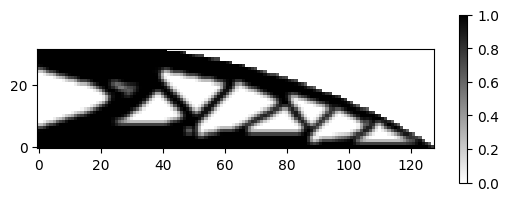

Text(0, 0.5, 'Mass')

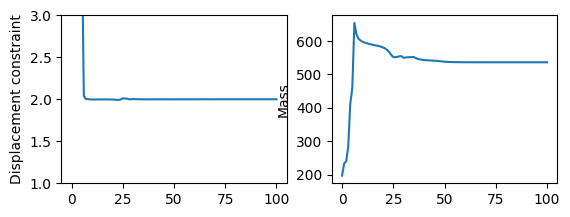

In [ ]:
plt.figure()
plt.subplot(2, 1, 1)
plt.imshow(designs[-1].reshape(nely, nelx), cmap = 'gray_r',
           vmin = 0.0, vmax = 1.0, origin = 'lower')
plt.colorbar()
plt.show()

plt.subplot(2, 2, 3)
plt.plot(np.array(losses) + 2.0)
plt.ylim(1, 3)
plt.ylabel('Displacement constraint')

plt.subplot(2, 2, 4)
plt.plot(np.array(masses) *  0.1 * 2.7)
plt.ylabel('Mass')

Maximum vertical displacement: 1.998
Mass 542.325


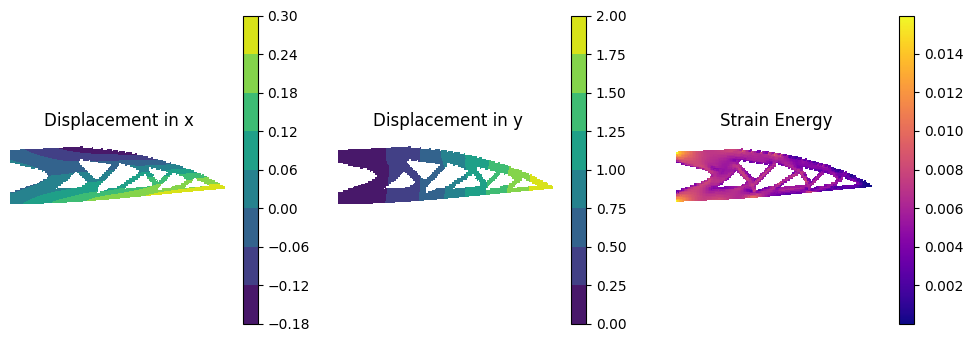

In [ ]:
x0 = designs[-1].reshape(32, 128)
results = simulate(args, x0, filtering = False)
strain_energy, displacement, mass = results


plot_results(results, x0,
             mesh_deformation_scale= 0.3,
             power_scale = 0.3,
             mask_strain_energy = True)

print("Maximum vertical displacement: {:.3f}".format(np.max(displacement[:, :, 1])))
print("Mass {:.3f}".format(mass))

## Let's see the optimization history!

Let's take a look at snapshots from the optimization, where we see all 100 designs, and how the optimizer keeps improving them.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

def animate_designs(designs):
    fig, ax = plt.subplots()

    def update(i):
        ax.clear()
        ax.imshow(designs[::-1, :, i], cmap='gray_r', vmin=0, vmax=1)
        ax.axis('off')

    ani = animation.FuncAnimation(fig, update, frames=designs.shape[2], interval=200)
    plt.close()  # Close the plot to prevent it from displaying statically

    return ani

In [ ]:
ani = animate_designs(np.array(designs).transpose(1, 2, 0))
HTML(ani.to_jshtml())